In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

from satforecast.data import data
from satforecast.modeling.model_selection import rolling_batch
from satforecast.modeling.train import train

data.download()
image_dir = data.process_gs_rainfall_daily(scale=0.1)
image_files = data.get_files(image_dir, '*.npy')

In [2]:
class PermuteLayer(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(*self.dims)

class FlattenLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.flatten(start_dim=1, end_dim=-1)

class CNN3D(nn.Module):
    def __init__(self,
            seq_len = 5, # Data
            image_size = (60, 180),
            in_channels = 1, # Conv
            conv_channels = 2,
            conv_kernels = 3,
            conv_stride = 3,
            conv_padding = 1,
            pool_kernels = 2, # Pool
            pool_stride = 2,
            pool_padding = 1,
            linear_feats = [] # Linear
            ):
        super().__init__()
        
        # Permute and flatten layers
        # Input: (batch_size, seq_len, n_channels, height, width)
        input_to_conv3d = (0, 2, 1, 3, 4) # (batch_size, n_channels, seq_len, height, width)
        input_to_conv3d_permute = PermuteLayer(input_to_conv3d)
        conv3d_to_flatten = (0, 2, 3, 4, 1) # (batch_size, seq_len, height, width, x_channels)
        conv3d_to_flatten_permute = PermuteLayer(conv3d_to_flatten)
        flatten = FlattenLayer() # (batch_size, seq_len * height * width, x_channels)
        #conv3d_to_flatten_permute = PermuteLayer(conv3d_to_linear)
        
        # Flatten layer
        

        # Convolutional layers
        if type(conv_channels) is int:
            conv_channels = [conv_channels]

        conv_steps = len(conv_channels)

        if type(conv_kernels) is int:
            conv_kernels = [conv_kernels] * conv_steps
            conv_stride = [conv_stride] * conv_steps
            conv_padding = [conv_padding] * conv_steps
            pool_kernels = [pool_kernels] * conv_steps
            pool_stride = [pool_stride] * conv_steps
            pool_padding = [pool_padding] * conv_steps

        conv_layers = []
        for in_c, out_c, c_kern, c_stride, c_pad, p_kern, p_stride, p_pad in zip(
                [in_channels] + conv_channels[:-1],
                conv_channels,
                conv_kernels, conv_stride, conv_padding,
                pool_kernels, pool_stride, pool_padding
        ):
            conv_layers.extend([
                nn.Conv3d(in_c, out_c, c_kern, c_stride, c_pad),
                nn.BatchNorm3d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool3d(p_kern, p_stride, p_pad)
            ])

        # Calculate output shape of convolutional layers
        with torch.no_grad():
            test_tensor = torch.zeros(1, seq_len, in_channels, image_size[0], image_size[1])
            test_tensor = input_to_conv3d_permute(test_tensor)
            test_tensor = nn.Sequential(*conv_layers)(test_tensor)
            test_tensor = conv3d_to_flatten_permute(test_tensor)
            test_tensor = flatten(test_tensor)
            conv_output_shape = test_tensor.shape

        # Fully connected layers
        if type(linear_feats) is int:
            linear_feats = [linear_feats]

        linear_feats = [
            np.prod(conv_output_shape),
            *linear_feats,
            in_channels * np.prod(image_size)
        ]

        fc_layers = []
        for in_feats, out_feats in zip(linear_feats[:-1], linear_feats[1:]):
            fc_layers.extend([
                nn.Linear(in_feats, out_feats),
                nn.ReLU(inplace=True)
            ])

        # Full Model
        self.model = nn.Sequential(
            input_to_conv3d_permute, *conv_layers,
            conv3d_to_flatten_permute, flatten, *fc_layers
        )

    def forward(self, x):
        batch_size, _, n_channels, height, width = x.shape
        return self.model(x).view(batch_size, n_channels, height, width)
    
    def predict(self, x):
        return self.forward(x)

CNN3D(
  (model): Sequential(
    (0): PermuteLayer()
    (1): Conv3d(1, 2, kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=(1, 1, 1))
    (2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): PermuteLayer()
    (6): FlattenLayer()
    (7): Linear(in_features=1364, out_features=10800, bias=True)
    (8): ReLU(inplace=True)
  )
)
Batch 0: Validation loss = 0.07815253734588623, Train time = 0.0, Update time = 0.2, Validation time = 0.0
Batch 1: Validation loss = 0.08097156882286072, Train time = 0.0, Update time = 0.2, Validation time = 0.0

!!! Early stopping triggered after 0 epochs and 2 batches !!!



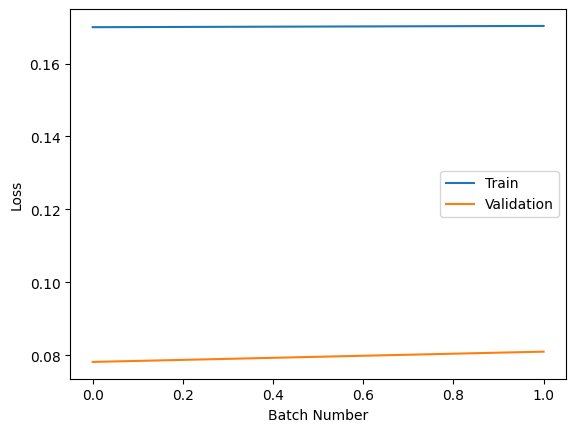

In [3]:
# Test run
TEST_N_IMAGES = 100
test_image_files = image_files[:TEST_N_IMAGES]
test_cnn3d = CNN3D(
    seq_len = 5, # Data
    image_size = (60, 180),
    in_channels = 1, # Conv
    conv_channels = 2,
    conv_kernels = 3,
    conv_stride = 3,
    conv_padding = 1,
    pool_kernels = 2, # Pool
    pool_stride = 2,
    pool_padding = 1,
    linear_feats = [] # Linear
)

print(test_cnn3d)

train_loss, val_loss = train(
    model = test_cnn3d,
    model_name = 'test_cnn3d_v0',
    criterion = nn.MSELoss(),
    optimizer = torch.optim.Adam(test_cnn3d.parameters()),
    files_list = test_image_files,
    train_frac = 0.6,
    val_frac = 0.1,
    seq_len = 5,
    batch_size = 5,
    max_epochs = 3,
    val_level = 'batch',
    early_stopping = True,
    min_improv = 0.003,
    max_iter_improv = 1,
    log_level = 1
)

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

## Semi-full training

In [ ]:
# Data constants
DEV_N_IMAGES = 2_000
TRAIN_FRAC = 0.6
VAL_FRAC = 0.05
SEQ_LEN = 5

dev_image_files = image_files[:DEV_N_IMAGES]

# Model
dev_cnn3d = CNN3D(
    seq_len = SEQ_LEN, # Data
    image_size = (60, 180),
    in_channels = 1, # Conv
    conv_channels = 2,
    conv_kernels = 3,
    conv_stride = 1,
    conv_padding = 1,
    pool_kernels = 2, # Pool
    pool_stride = 1,
    pool_padding = 1,
    linear_feats = [] # Linear
)
model_name = 'dev_cnn3d_v0'
crit = nn.MSELoss()
optim = torch.optim.Adam(dev_cnn3d.parameters())

# Training constants
BATCH_SIZE = 1
MAX_EPOCHS = 3
MIN_IMPROV = 0.001
MAX_ITER_IMPROV = 3

train_loss, val_loss = train(
    model = dev_cnn3d,
    model_name = model_name,
    criterion = crit,
    optimizer = optim,
    files_list = dev_image_files,
    train_frac = TRAIN_FRAC,
    val_frac = VAL_FRAC,
    seq_len = SEQ_LEN,
    batch_size = BATCH_SIZE,
    max_epochs = MAX_EPOCHS,
    val_level = 'batch',
    early_stopping = True,
    min_improv = MIN_IMPROV,
    max_iter_improv = MAX_ITER_IMPROV,
    log_level = 2
)

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');